[![Roboflow Notebooks](https://ik.imagekit.io/roboflow/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# How to Use PolygonZone and Roboflow Supervision

In this notebook, you will use [PolygonZone](https://roboflow.github.io/polygonzone/) with [Roboflow Supervision](https://roboflow.com/supervision) to draw polygons on a video frame. These polygons will be used as zones in which predictions will be grouped.

This notebook accompanies the "Calculate Polygon Coordinates with PolygonZone" tutorial on the Roboflow blog.

## Pro Tip: Use GPU Acceleration

If you are running this notebook in Google Colab, navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`. This will ensure your notebook uses a GPU, which will significantly speed up model training times.

## Steps in this Tutorial

In this guide, we will:

1. Install supervision and YOLOv8.
2. Prepare polygon zones for a traffic video.
3. Run inference on a traffic video.
4. Save the results of inference to a file.

**Let's begin!**

## Install Dependencies and Retrieve Video

Install the required dependencies for this project. We'll be using Ultralytics' YOLOv8 model for inference, and Supervision for drawing our polygons and calculating how many objects appear in each annotated zone.

In [ ]:
!pip install supervision --quiet
!pip install ultralytics --quiet

In [42]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1K15ijbTl78VSOPjfvGSgvqh7ME2U7cG2' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1K15ijbTl78VSOPjfvGSgvqh7ME2U7cG2" -O video.mp4 && rm -rf /tmp/cookies.txt

--2023-02-13 10:48:51--  https://docs.google.com/uc?export=download&confirm=&id=1K15ijbTl78VSOPjfvGSgvqh7ME2U7cG2
Resolving docs.google.com (docs.google.com)... 172.253.115.101, 172.253.115.113, 172.253.115.139, ...
Connecting to docs.google.com (docs.google.com)|172.253.115.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0g-74-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/u4vqok7firdne6qt1j498c5ldlc01f5o/1676285325000/03796184128890941253/*/1K15ijbTl78VSOPjfvGSgvqh7ME2U7cG2?e=download&uuid=19a0fac4-d12f-4ac6-8ea6-f7271dd3a2ec [following]
--2023-02-13 10:48:51--  https://doc-0g-74-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/u4vqok7firdne6qt1j498c5ldlc01f5o/1676285325000/03796184128890941253/*/1K15ijbTl78VSOPjfvGSgvqh7ME2U7cG2?e=download&uuid=19a0fac4-d12f-4ac6-8ea6-f7271dd3a2ec
Resolving doc-0g-74-docs.googleusercontent.com (doc-0g-74-docs.googleusercontent.com)... 172.253.63.13

## Initialize the Model and Video

In the code snippet below, we import the required dependencies for our project, initialize a YOLOv8 model, and load a video into our project.

In [37]:
import numpy as np
import supervision as sv
import cv2

from ultralytics import YOLO

model = YOLO('yolov8s.pt')

VIDEO = "video.mp4"

video_info = sv.VideoInfo.from_video_path(VIDEO)
colors = sv.ColorPalette.default()

## Save Frame

The code snippet below saves the first frame in your video to a file called "first_frame.png".

In [44]:
# extract video frame
generator = sv.get_video_frames_generator(VIDEO)
iterator = iter(generator)

frame = next(iterator)

# save first frame
cv2.imwrite("first_frame.png", frame)

True

Next, go to [PolygonZone](https://roboflow.github.io/polygonzone/) and draw polygons on your image. PolygonZone returns a list of polygon coordinates in both NumPy and JSON formats. Copy the NumPy output into the cell below:

In [45]:
polygons = [
np.array([
[733, 583],[942, 586],[921, 1065],[36, 1071],[5, 980]
]),np.array([
[987, 592],[1205, 602],[1912, 1011],[1875, 1071],[1008, 1062]
])
]

## Run Inference

Using the YOLOv8 model we initialized earlier, as well as our Supervision objects, we can draw polygons on the first frame on our image and count the number of objects that appear.

First, let's initialize our zones:

In [46]:
# initialize our zones

zones = [
    sv.PolygonZone(
        polygon=polygon, 
        frame_resolution_wh=video_info.resolution_wh
    )
    for polygon
    in polygons
]
zone_annotators = [
    sv.PolygonZoneAnnotator(
        zone=zone, 
        color=colors.by_idx(index), 
        thickness=4,
        text_thickness=8,
        text_scale=4
    )
    for index, zone
    in enumerate(zones)
]
box_annotators = [
    sv.BoxAnnotator(
        color=colors.by_idx(index), 
        thickness=4, 
        text_thickness=4, 
        text_scale=2
        )
    for index
    in range(len(polygons))
]

def process_frame(frame: np.ndarray, i) -> np.ndarray:
    results = model(frame, imgsz=1280)[0]
    detections = sv.Detections.from_yolov8(results)

    for zone, zone_annotator, box_annotator in zip(zones, zone_annotators, box_annotators):
        mask = zone.trigger(detections=detections)
        detections_filtered = detections[mask]
        frame = box_annotator.annotate(scene=frame, detections=detections_filtered, skip_label=True)
        frame = zone_annotator.annotate(scene=frame)

    return frame

Now we can run inference. Let's run inference on a single frame so we can make sure everything is working as expected:


0: 736x1280 34 cars, 2 buss, 6 trucks, 5 traffic lights, 31.0ms
Speed: 1.1ms pre-process, 31.0ms inference, 1.5ms postprocess per image at shape (1, 3, 1280, 1280)


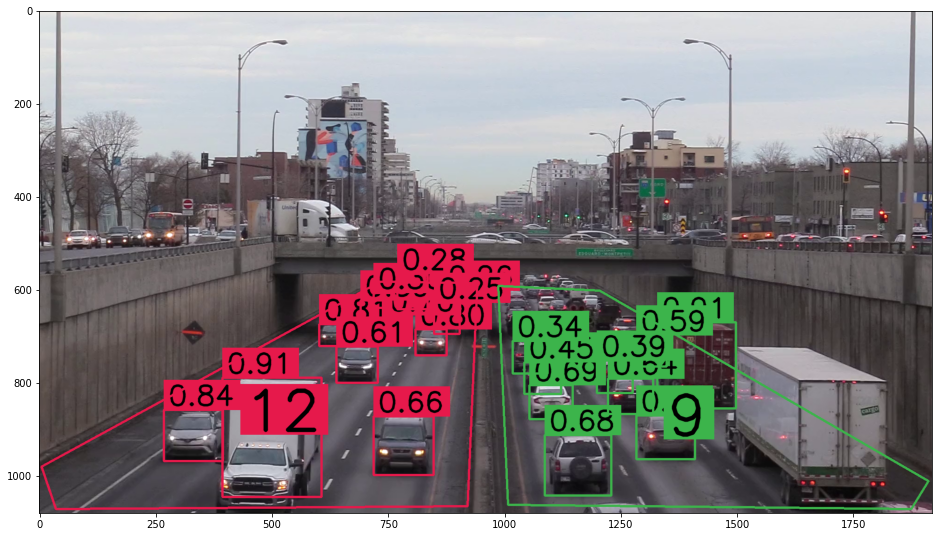

In [47]:
results = model(frame, imgsz=1280)[0]
detections = sv.Detections.from_yolov8(results)

for zone, zone_annotator, box_annotator in zip(zones, zone_annotators, box_annotators):
    mask = zone.trigger(detections=detections)
    detections_filtered = detections[mask]
    frame = box_annotator.annotate(scene=frame, detections=detections_filtered)
    frame = zone_annotator.annotate(scene=frame)

sv.show_frame_in_notebook(frame, (16, 16))

The frame above shows all of the predictions in the polygons we have drawn. Now we can proceed to run inference on the rest of the video.

## Video Inference

Use the code snippet below to run inference on the video you specified earlier and save the results to "result.mp4".

In [ ]:
sv.process_video(source_path=VIDEO, target_path=f"result.mp4", callback=process_frame)



0: 736x1280 34 cars, 2 buss, 6 trucks, 5 traffic lights, 30.6ms
Speed: 1.1ms pre-process, 30.6ms inference, 2.2ms postprocess per image at shape (1, 3, 1280, 1280)

0: 736x1280 30 cars, 2 buss, 7 trucks, 6 traffic lights, 30.5ms
Speed: 1.0ms pre-process, 30.5ms inference, 1.8ms postprocess per image at shape (1, 3, 1280, 1280)

0: 736x1280 34 cars, 2 buss, 8 trucks, 6 traffic lights, 30.5ms
Speed: 1.1ms pre-process, 30.5ms inference, 3.4ms postprocess per image at shape (1, 3, 1280, 1280)

0: 736x1280 33 cars, 2 buss, 4 trucks, 6 traffic lights, 30.7ms
Speed: 1.1ms pre-process, 30.7ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 1280)

0: 736x1280 34 cars, 2 buss, 6 trucks, 7 traffic lights, 30.8ms
Speed: 1.1ms pre-process, 30.8ms inference, 2.3ms postprocess per image at shape (1, 3, 1280, 1280)

0: 736x1280 33 cars, 2 buss, 6 trucks, 5 traffic lights, 30.7ms
Speed: 1.1ms pre-process, 30.7ms inference, 1.5ms postprocess per image at shape (1, 3, 1280, 1280)

0: 736x12